<font size="5">データセットの分割</font>

In [3]:
from IPython.display import Image
%matplotlib inline

# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
#データを訓練とテスト用に分割
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

<font size="5">特徴量のスケーリング</font>

In [5]:
from sklearn.preprocessing import MinMaxScaler

# min-maxスケーリングによる[0,1]の範囲へスケーリング
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [6]:
# 標準化
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [7]:
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])

# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.46385,0.0
1,1,-0.87831,0.2
2,2,-0.29277,0.4
3,3,0.29277,0.6
4,4,0.87831,0.8
5,5,1.46385,1.0


<font size="5">正則化によるパラメータの重み係数（ロジスティック回帰に対して）</font>

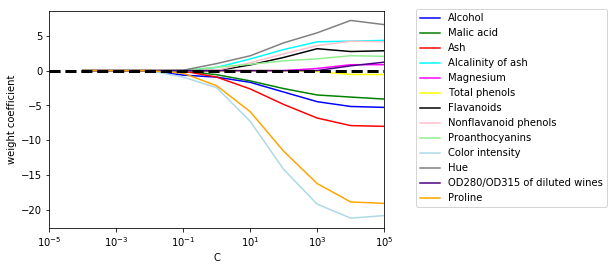

In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

<font size="5">特徴選択アルゴリズム</font>

In [10]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

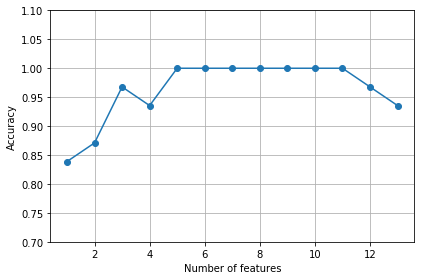

In [11]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [12]:
#特徴アルゴリズムを適用して得られた結果
# (上の図でk=5のとき100%精度を達成していることに注目)
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [13]:
# 訓練とテストの精度を表示 (13個全ての)
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [14]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963
